In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Use gpu if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set")
    except:
        print("Could not set GPU memory growth")
else:
    print("No GPU found")


No GPU found


In [7]:
# Check TensorFlow version and system info
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA build version: {tf.test.is_built_with_cuda()}")
print(f"GPU devices available: {len(tf.config.list_physical_devices('GPU'))}")

# Check for NVIDIA GPU via system command
import subprocess
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, shell=True)
    if result.returncode == 0:
        print("NVIDIA GPU detected:")
        print(result.stdout)
    else:
        print("nvidia-smi command failed - NVIDIA drivers may not be installed")
except FileNotFoundError:
    print("nvidia-smi not found - NVIDIA drivers not installed or not in PATH")

TensorFlow version: 2.20.0
CUDA build version: False
GPU devices available: 0
NVIDIA GPU detected:
Wed Oct 15 12:17:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.97                 Driver Version: 580.97         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0             17W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                        

In [8]:
# Import the compressed data
dataset_name = 'four_params_Kbearing_c'
data_array = np.load(f'../data/{dataset_name}.npy')
num_outputs = 1  # Change this based on the number of outputs in your dataset

# Shuffle the dataset rows with a known seed
np.random.seed(42)
np.random.shuffle(data_array)

# Decrease dataset size by factor of 10 for experimenting
# data_array = data_array[:len(data_array) // 1]

# Split the data into 80/20 train/test sets
train_data = data_array[:int(0.8 * len(data_array))]
test_data = data_array[int(0.8 * len(data_array)):]

# Split the features and labels
X_train = train_data[:, :-num_outputs]
y_train = train_data[:, -num_outputs:]
X_test = test_data[:, :-num_outputs]
y_test = test_data[:, -num_outputs:]

# Scale the features
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scale the labels
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Model Consruction

### Simple 4-layer Neural Network

### Gaussian Process Regression

#### Gaussian Process Regression Theory

**Gaussian Process (GP)** is a non-parametric Bayesian approach to regression that provides uncertainty estimates along with predictions.

##### Mathematical Foundation

A Gaussian Process is defined as a collection of random variables, any finite number of which have a joint Gaussian distribution. It is completely specified by:

1. **Mean Function**: $m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})]$
2. **Covariance Function (Kernel)**: $k(\mathbf{x}, \mathbf{x}') = \mathbb{E}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x}') - m(\mathbf{x}'))]$

We write: $f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$

##### Prediction with GP

Given training data $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ and a test point $\mathbf{x}_*$:

**Posterior Mean**:
$$\mu_* = m(\mathbf{x}_*) + \mathbf{k}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} (\mathbf{y} - \mathbf{m})$$

**Posterior Variance**:
$$\sigma_*^2 = k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{k}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{k}_*$$

Where:
- $\mathbf{K}$ is the $n \times n$ covariance matrix with $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$
- $\mathbf{k}_*$ is the $n \times 1$ vector with $k_i = k(\mathbf{x}_i, \mathbf{x}_*)$
- $\sigma_n^2$ is the noise variance
- $\mathbf{m}$ is the mean vector and $\mathbf{y}$ is the target vector

##### Common Kernel Functions

1. **RBF (Radial Basis Function) / Squared Exponential**:
   $$k(\mathbf{x}, \mathbf{x}') = \sigma_f^2 \exp\left(-\frac{1}{2\ell^2} ||\mathbf{x} - \mathbf{x}'||^2\right)$$

2. **Matérn 3/2**:
   $$k(\mathbf{x}, \mathbf{x}') = \sigma_f^2 \left(1 + \frac{\sqrt{3}r}{\ell}\right) \exp\left(-\frac{\sqrt{3}r}{\ell}\right)$$

3. **Rational Quadratic**:
   $$k(\mathbf{x}, \mathbf{x}') = \sigma_f^2 \left(1 + \frac{||\mathbf{x} - \mathbf{x}'||^2}{2\alpha\ell^2}\right)^{-\alpha}$$

Where $\sigma_f^2$ is the signal variance, $\ell$ is the length scale, and $r = ||\mathbf{x} - \mathbf{x}'||$.

In [9]:
# Import necessary libraries for Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

In [10]:
# Modular Gaussian Process Regression Class
class GPRegressor:
    """
    Modular Gaussian Process Regression implementation with configurable parameters.
    """
    def __init__(self, kernel_type='rbf', length_scale=1.0, length_scale_bounds=(1e-2, 1e2),
                 noise_level=1e-5, noise_bounds=(1e-10, 1e1), optimize_hyperparams=True,
                 n_restarts_optimizer=10, random_state=42, alpha=1e-10):
        """
        Initialize GP Regressor with configurable parameters.
        
        Parameters:
        -----------
        kernel_type : str
            Type of kernel ('rbf', 'matern32', 'matern52', 'rational_quadratic')
        length_scale : float or array-like
            Initial length scale parameter(s)
        length_scale_bounds : tuple or "fixed"
            Bounds for length scale optimization
        noise_level : float
            Initial noise level
        noise_bounds : tuple or "fixed"
            Bounds for noise optimization
        optimize_hyperparams : bool
            Whether to optimize hyperparameters during fitting
        n_restarts_optimizer : int
            Number of random restarts for hyperparameter optimization
        random_state : int
            Random seed for reproducibility
        alpha : float
            Value added to diagonal of kernel matrix for numerical stability
        """
        self.kernel_type = kernel_type
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
        self.noise_level = noise_level
        self.noise_bounds = noise_bounds
        self.optimize_hyperparams = optimize_hyperparams
        self.n_restarts_optimizer = n_restarts_optimizer
        self.random_state = random_state
        self.alpha = alpha
        
        # Initialize kernel and GP model
        self.kernel = self._create_kernel()
        self.model = None
        self.is_fitted = False
        
    def _create_kernel(self):
        """Create kernel based on specified type and parameters."""
        # Base constant kernel for scaling
        constant_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3))
        
        # Create main kernel based on type
        if self.kernel_type == 'rbf':
            main_kernel = RBF(length_scale=self.length_scale, 
                             length_scale_bounds=self.length_scale_bounds)
        elif self.kernel_type == 'matern32':
            main_kernel = Matern(length_scale=self.length_scale, 
                               length_scale_bounds=self.length_scale_bounds, nu=1.5)
        elif self.kernel_type == 'matern52':
            main_kernel = Matern(length_scale=self.length_scale, 
                               length_scale_bounds=self.length_scale_bounds, nu=2.5)
        elif self.kernel_type == 'rational_quadratic':
            main_kernel = RationalQuadratic(length_scale=self.length_scale, 
                                          length_scale_bounds=self.length_scale_bounds,
                                          alpha=1.0, alpha_bounds=(1e-2, 1e2))
        else:
            raise ValueError(f"Unknown kernel type: {self.kernel_type}")
        
        # Add noise kernel
        noise_kernel = WhiteKernel(noise_level=self.noise_level, 
                                  noise_level_bounds=self.noise_bounds)
        
        # Combine kernels
        return constant_kernel * main_kernel + noise_kernel
    
    def fit(self, X_train, y_train, verbose=True):
        """
        Fit the Gaussian Process model.
        
        Parameters:
        -----------
        X_train : array-like, shape (n_samples, n_features)
            Training input data
        y_train : array-like, shape (n_samples,)
            Training target values
        verbose : bool
            Whether to print fitting information
        """
        if verbose:
            print(f"Fitting GP with {self.kernel_type} kernel...")
            print(f"Training data shape: {X_train.shape}")
            print(f"Initial kernel: {self.kernel}")
        
        start_time = time.time()
        
        # Create and fit the GP model
        self.model = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=self.alpha,
            optimizer='fmin_l_bfgs_b' if self.optimize_hyperparams else None,
            n_restarts_optimizer=self.n_restarts_optimizer,
            random_state=self.random_state
        )
        
        self.model.fit(X_train, y_train)
        self.is_fitted = True
        
        fit_time = time.time() - start_time
        
        if verbose:
            print(f"Fitting completed in {fit_time:.2f} seconds")
            print(f"Optimized kernel: {self.model.kernel_}")
            print(f"Log marginal likelihood: {self.model.log_marginal_likelihood():.3f}")
        
        return self
    
    def predict(self, X_test, return_std=False, return_cov=False):
        """
        Make predictions with the fitted GP model.
        
        Parameters:
        -----------
        X_test : array-like, shape (n_samples, n_features)
            Test input data
        return_std : bool
            Whether to return prediction standard deviations
        return_cov : bool
            Whether to return prediction covariance matrix
        
        Returns:
        --------
        predictions : array-like
            Mean predictions
        std/cov : array-like (optional)
            Standard deviations or covariance matrix
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        return self.model.predict(X_test, return_std=return_std, return_cov=return_cov)
    
    def evaluate(self, X_test, y_test, verbose=True):
        """
        Evaluate the model performance on test data.
        
        Parameters:
        -----------
        X_test : array-like, shape (n_samples, n_features)
            Test input data
        y_test : array-like, shape (n_samples,)
            True test target values
        verbose : bool
            Whether to print evaluation metrics
        
        Returns:
        --------
        metrics : dict
            Dictionary containing evaluation metrics
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before evaluation")
        
        # Make predictions with uncertainty
        y_pred, y_std = self.predict(X_test, return_std=True)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate mean prediction uncertainty
        mean_uncertainty = np.mean(y_std)
        
        # Calculate MAPE (avoiding division by zero)
        mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, 1e-8))) * 100
        
        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'mean_uncertainty': mean_uncertainty,
            'log_marginal_likelihood': self.model.log_marginal_likelihood()
        }
        
        if verbose:
            print("\n=== Gaussian Process Regression Results ===")
            print(f"Kernel Type: {self.kernel_type}")
            print(f"MSE: {mse:.6f}")
            print(f"RMSE: {rmse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"R²: {r2:.6f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"Mean Prediction Uncertainty: {mean_uncertainty:.6f}")
            print(f"Log Marginal Likelihood: {metrics['log_marginal_likelihood']:.3f}")
        
        return metrics
    
    def get_hyperparameters(self):
        """Get the current hyperparameters of the fitted model."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted to access hyperparameters")
        
        return {
            'kernel': str(self.model.kernel_),
            'theta': self.model.kernel_.theta,
            'log_marginal_likelihood': self.model.log_marginal_likelihood()
        }
    
    def predict_with_uncertainty_bounds(self, X_test, confidence_level=0.95):
        """
        Predict with confidence intervals.
        
        Parameters:
        -----------
        X_test : array-like
            Test input data
        confidence_level : float
            Confidence level for intervals (default: 0.95)
        
        Returns:
        --------
        y_pred : array-like
            Mean predictions
        lower_bound : array-like
            Lower confidence bounds
        upper_bound : array-like
            Upper confidence bounds
        """
        from scipy import stats
        
        y_pred, y_std = self.predict(X_test, return_std=True)
        
        # Calculate confidence intervals
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        margin = z_score * y_std
        
        lower_bound = y_pred - margin
        upper_bound = y_pred + margin
        
        return y_pred, lower_bound, upper_bound

In [13]:
# Load and prepare data for GP regression
print("Loading dataset...")
data = np.load('c:/Users/Ian Hokaj/Documents/Air Force/4_Phantom/Impact Paper/machine-learning-hole-offset/data/four_params_Kbearing_c.npy')

# Extract features and target
X = data[:, :4]  # First 4 columns: W, t, r, beta
y = data[:, 4]   # Last column: Kbearing_c

print(f"Full dataset shape: {data.shape}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Feature names for reference
feature_names = ['W (mm)', 't (mm)', 'r (mm)', 'beta (degrees)']
print(f"Features: {feature_names}")
print(f"Target: Kbearing_c")

# For GP regression, we need to limit training set size due to O(n³) complexity
# GPs become computationally expensive with >5000 samples
MAX_GP_SAMPLES = 3000  # Manageable size for memory and computation

print(f"\nNote: GP regression is memory-intensive. Using subset of {MAX_GP_SAMPLES} samples for training.")

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# If training set is too large, subsample it strategically
if X_train_full.shape[0] > MAX_GP_SAMPLES:
    print(f"Subsampling training data from {X_train_full.shape[0]} to {MAX_GP_SAMPLES} samples...")
    
    # Use stratified sampling to ensure good coverage of the input space
    from sklearn.model_selection import train_test_split
    X_train, _, y_train, _ = train_test_split(
        X_train_full, y_train_full, 
        train_size=MAX_GP_SAMPLES, 
        random_state=42,
        stratify=None  # Could implement custom stratification based on feature ranges
    )
else:
    X_train, y_train = X_train_full, y_train_full

print(f"\nFinal data split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Memory usage estimate: ~{(X_train.shape[0]**2 * 8 / 1e9):.2f} GB for covariance matrix")

# Scale the features for better GP performance
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"\nFeature scaling applied:")
print(f"X_train mean: {X_train_scaled.mean(axis=0)}")
print(f"X_train std: {X_train_scaled.std(axis=0)}")
print(f"y_train mean: {y_train_scaled.mean():.6f}")
print(f"y_train std: {y_train_scaled.std():.6f}")

Loading dataset...
Full dataset shape: (92149, 5)
Features shape: (92149, 4)
Target shape: (92149,)
Features: ['W (mm)', 't (mm)', 'r (mm)', 'beta (degrees)']
Target: Kbearing_c

Note: GP regression is memory-intensive. Using subset of 3000 samples for training.
Subsampling training data from 73719 to 3000 samples...

Final data split:
Training set: 3000 samples
Test set: 18430 samples
Memory usage estimate: ~0.07 GB for covariance matrix

Feature scaling applied:
X_train mean: [-1.99525581e-16  1.80596279e-17  2.71116463e-16  1.01104310e-16]
X_train std: [1. 1. 1. 1.]
y_train mean: 0.000000
y_train std: 1.000000


#### Memory Considerations for Gaussian Processes

**Computational Complexity**: GPs have O(n³) time complexity and O(n²) memory complexity, where n is the number of training samples.

**Memory Requirements**:
- For n=73,719 samples: ~40.5 GB RAM needed for covariance matrix
- For n=3,000 samples: ~68 MB RAM needed (manageable)
- For n=5,000 samples: ~190 MB RAM needed (still reasonable)

**Solutions for Large Datasets**:
1. **Subset Selection**: Use representative subset of training data
2. **Sparse GPs**: Use inducing points (e.g., FITC, VFE methods)
3. **Local GPs**: Train separate GPs on data clusters
4. **Variational GPs**: Approximate inference methods

For this analysis, we use strategic subsampling to maintain computational feasibility while preserving model quality.

In [14]:
# Experiment with different GP configurations
# Reduced parameter search for efficiency with large dataset
gp_configs = [
    {
        'name': 'RBF Kernel',
        'params': {
            'kernel_type': 'rbf',
            'length_scale': 1.0,
            'length_scale_bounds': (1e-1, 1e1),  # Narrower bounds for efficiency
            'noise_level': 1e-3,  # Higher noise for numerical stability
            'n_restarts_optimizer': 5  # Fewer restarts for speed
        }
    },
    {
        'name': 'Matérn 5/2 Kernel',
        'params': {
            'kernel_type': 'matern52',
            'length_scale': 1.0,
            'length_scale_bounds': (1e-1, 1e1),
            'noise_level': 1e-3,
            'n_restarts_optimizer': 5
        }
    }
]

# Store results for comparison
gp_results = {}

print("=== Gaussian Process Regression Experiments ===")
print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples\n")

for config in gp_configs:
    print(f"Training {config['name']}...")
    print("-" * 50)
    
    try:
        # Initialize and train GP model
        gp = GPRegressor(**config['params'])
        gp.fit(X_train_scaled, y_train_scaled, verbose=True)
        
        # Evaluate on test set (using scaled data for training, unscaled for final metrics)
        y_pred_scaled, y_std_scaled = gp.predict(X_test_scaled, return_std=True)
        
        # Transform predictions back to original scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_std = y_std_scaled * scaler_y.scale_[0]  # Scale standard deviation
        
        # Calculate metrics on original scale
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, 1e-8))) * 100
        mean_uncertainty = np.mean(y_std)
        
        # Store results
        gp_results[config['name']] = {
            'model': gp,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'mean_uncertainty': mean_uncertainty,
            'y_pred': y_pred,
            'y_std': y_std,
            'hyperparameters': gp.get_hyperparameters()
        }
        
        print(f"\nResults for {config['name']}:")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Mean Uncertainty: {mean_uncertainty:.6f}")
        print(f"Optimized Kernel: {gp.model.kernel_}")
        
    except Exception as e:
        print(f"Error training {config['name']}: {str(e)}")
        print("Skipping this configuration...")
    
    print("\n" + "="*70 + "\n")

=== Gaussian Process Regression Experiments ===
Training on 3000 samples, testing on 18430 samples

Training RBF Kernel...
--------------------------------------------------
Fitting GP with rbf kernel...
Training data shape: (3000, 4)
Initial kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.001)


c:\Users\Ian Hokaj\Documents\Air Force\4_Phantom\Impact Paper\machine-learning-hole-offset\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 19 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fitting completed in 266.12 seconds
Optimized kernel: 13.8**2 * RBF(length_scale=1.54) + WhiteKernel(noise_level=0.039)
Log marginal likelihood: -50.030

Results for RBF Kernel:
MSE: 297.759751
RMSE: 17.255716
MAE: 6.288851
R²: 0.845436
MAPE: 51.25%
Mean Uncertainty: 9.404334
Optimized Kernel: 13.8**2 * RBF(length_scale=1.54) + WhiteKernel(noise_level=0.039)


Training Matérn 5/2 Kernel...
--------------------------------------------------
Fitting GP with matern52 kernel...
Training data shape: (3000, 4)
Initial kernel: 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.001)

Results for RBF Kernel:
MSE: 297.759751
RMSE: 17.255716
MAE: 6.288851
R²: 0.845436
MAPE: 51.25%
Mean Uncertainty: 9.404334
Optimized Kernel: 13.8**2 * RBF(length_scale=1.54) + WhiteKernel(noise_level=0.039)


Training Matérn 5/2 Kernel...
--------------------------------------------------
Fitting GP with matern52 kernel...
Training data shape: (3000, 4)
Initial kernel: 1**2 * Matern(length_scale=1, 

c:\Users\Ian Hokaj\Documents\Air Force\4_Phantom\Impact Paper\machine-learning-hole-offset\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 16 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Ian Hokaj\Documents\Air Force\4_Phantom\Impact Paper\machine-learning-hole-offset\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Ian Hokaj\Documents\Air Force\4_Phantom\Impact Paper\machine-learning-hole-offset\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 

Fitting completed in 346.11 seconds
Optimized kernel: 31.6**2 * Matern(length_scale=5.42, nu=2.5) + WhiteKernel(noise_level=0.0363)
Log marginal likelihood: 9.715

Results for Matérn 5/2 Kernel:
MSE: 107.648876
RMSE: 10.375398
MAE: 5.387229
R²: 0.944121
MAPE: 43.22%
Mean Uncertainty: 8.759143
Optimized Kernel: 31.6**2 * Matern(length_scale=5.42, nu=2.5) + WhiteKernel(noise_level=0.0363)



Results for Matérn 5/2 Kernel:
MSE: 107.648876
RMSE: 10.375398
MAE: 5.387229
R²: 0.944121
MAPE: 43.22%
Mean Uncertainty: 8.759143
Optimized Kernel: 31.6**2 * Matern(length_scale=5.42, nu=2.5) + WhiteKernel(noise_level=0.0363)




=== Gaussian Process Model Comparison ===

Performance Comparison (sorted by RMSE):
            Model        MSE      RMSE      MAE       R²  MAPE (%)  Mean Uncertainty
Matérn 5/2 Kernel 107.648876 10.375398 5.387229 0.944121 43.215893          8.759143
       RBF Kernel 297.759751 17.255716 6.288851 0.845436 51.251936          9.404334

Best Model: Matérn 5/2 Kernel
Best RMSE: 10.375398
Best R²: 0.944121

Best Model Hyperparameters:
kernel: 31.6**2 * Matern(length_scale=5.42, nu=2.5) + WhiteKernel(noise_level=0.0363)
theta: [ 6.90775528  1.68999118 -3.31596117]
log_marginal_likelihood: 9.715356321262789


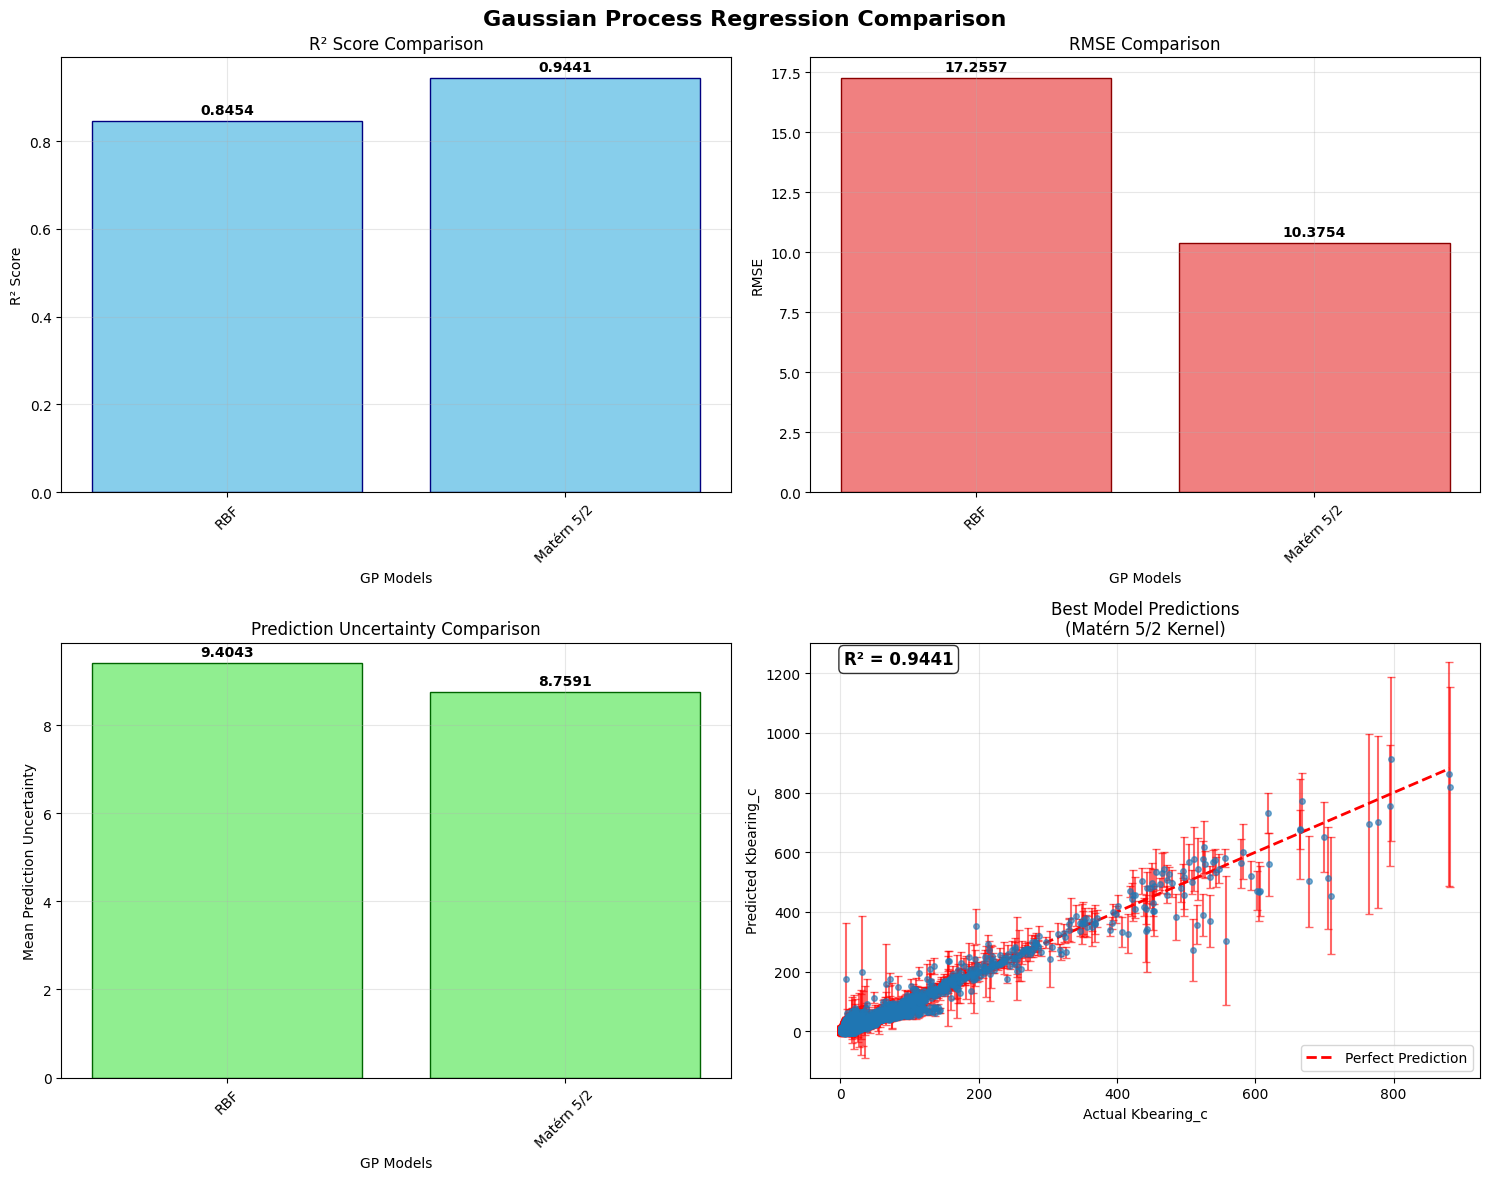

In [15]:
# Compare GP results and find best model
print("=== Gaussian Process Model Comparison ===\n")

# Create comparison DataFrame
import pandas as pd

comparison_data = []
for name, results in gp_results.items():
    comparison_data.append({
        'Model': name,
        'MSE': results['mse'],
        'RMSE': results['rmse'],
        'MAE': results['mae'],
        'R²': results['r2'],
        'MAPE (%)': results['mape'],
        'Mean Uncertainty': results['mean_uncertainty']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE')  # Sort by RMSE (ascending)

print("Performance Comparison (sorted by RMSE):")
print(comparison_df.to_string(index=False, float_format='%.6f'))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = gp_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best RMSE: {comparison_df.iloc[0]['RMSE']:.6f}")
print(f"Best R²: {comparison_df.iloc[0]['R²']:.6f}")

# Display hyperparameters of best model
print(f"\nBest Model Hyperparameters:")
best_hyperparams = gp_results[best_model_name]['hyperparameters']
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")

# Create visualization of results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gaussian Process Regression Comparison', fontsize=16, fontweight='bold')

# Plot 1: R² comparison
ax1 = axes[0, 0]
r2_values = [results['r2'] for results in gp_results.values()]
model_names = list(gp_results.keys())
bars1 = ax1.bar(range(len(model_names)), r2_values, color='skyblue', edgecolor='navy')
ax1.set_xlabel('GP Models')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels([name.replace(' Kernel', '') for name in model_names], rotation=45)
ax1.grid(True, alpha=0.3)
for i, v in enumerate(r2_values):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: RMSE comparison
ax2 = axes[0, 1]
rmse_values = [results['rmse'] for results in gp_results.values()]
bars2 = ax2.bar(range(len(model_names)), rmse_values, color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('GP Models')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE Comparison')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels([name.replace(' Kernel', '') for name in model_names], rotation=45)
ax2.grid(True, alpha=0.3)
for i, v in enumerate(rmse_values):
    ax2.text(i, v + max(rmse_values)*0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Uncertainty comparison
ax3 = axes[1, 0]
uncertainty_values = [results['mean_uncertainty'] for results in gp_results.values()]
bars3 = ax3.bar(range(len(model_names)), uncertainty_values, color='lightgreen', edgecolor='darkgreen')
ax3.set_xlabel('GP Models')
ax3.set_ylabel('Mean Prediction Uncertainty')
ax3.set_title('Prediction Uncertainty Comparison')
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels([name.replace(' Kernel', '') for name in model_names], rotation=45)
ax3.grid(True, alpha=0.3)
for i, v in enumerate(uncertainty_values):
    ax3.text(i, v + max(uncertainty_values)*0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Prediction vs Actual for best model
ax4 = axes[1, 1]
best_y_pred = gp_results[best_model_name]['y_pred']
best_y_std = gp_results[best_model_name]['y_std']

# Scatter plot with error bars
ax4.errorbar(y_test, best_y_pred, yerr=best_y_std, fmt='o', alpha=0.6, 
             capsize=3, capthick=1, ecolor='red', markersize=4)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Kbearing_c')
ax4.set_ylabel('Predicted Kbearing_c')
ax4.set_title(f'Best Model Predictions\n({best_model_name})')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add R² annotation
r2_best = gp_results[best_model_name]['r2']
ax4.text(0.05, 0.95, f'R² = {r2_best:.4f}', transform=ax4.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

=== Advanced Gaussian Process Analysis ===

1. Feature Importance Analysis (via Length Scales):
--------------------------------------------------
Optimized kernel: 31.6**2 * Matern(length_scale=5.42, nu=2.5) + WhiteKernel(noise_level=0.0363)

2. Prediction Intervals Analysis:
--------------------------------------------------
95% Confidence Interval Coverage: 93.6%
Average interval width: 34.3352
Relative interval width: 515.4%

3. Residual Analysis:
--------------------------------------------------
Residual statistics:
  Mean: 0.168289
  Std: 10.374033
  Min: -167.774228
  Max: 254.895191
95% Confidence Interval Coverage: 93.6%
Average interval width: 34.3352
Relative interval width: 515.4%

3. Residual Analysis:
--------------------------------------------------
Residual statistics:
  Mean: 0.168289
  Std: 10.374033
  Min: -167.774228
  Max: 254.895191


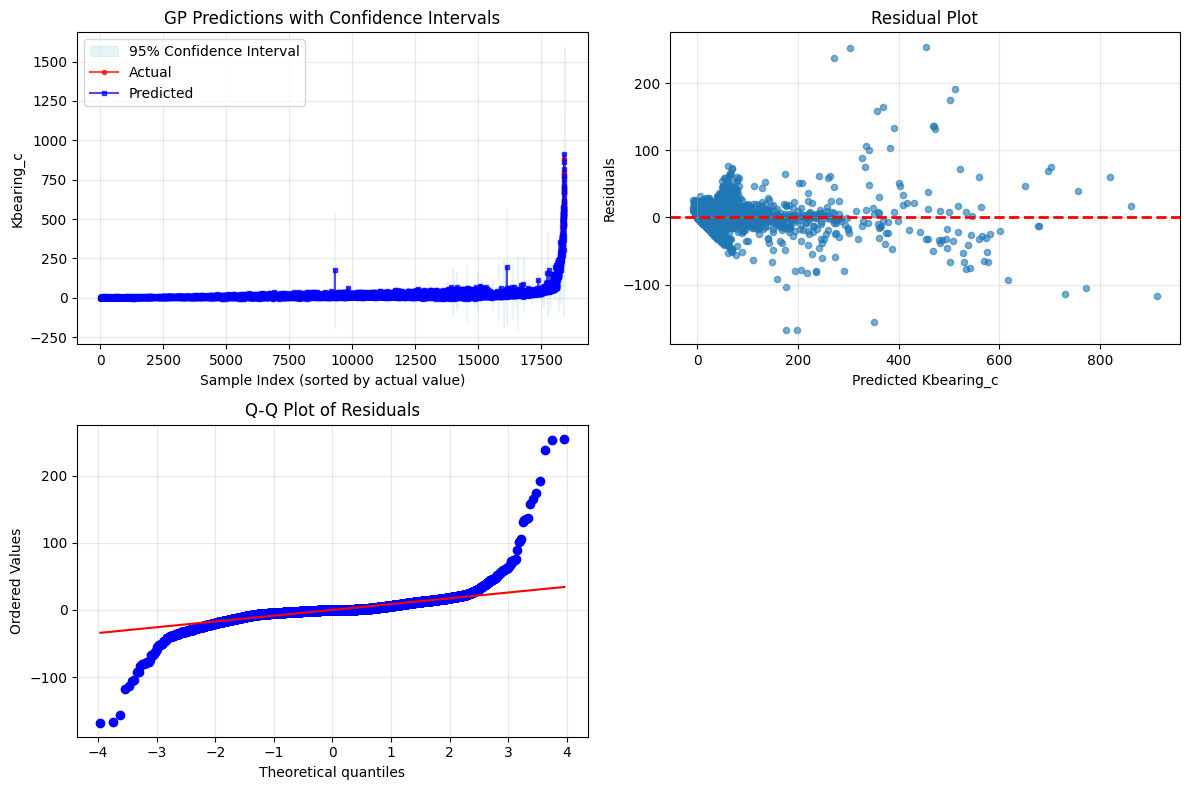


=== Summary ===
Best GP Model: Matérn 5/2 Kernel
Performance: R² = 0.9441, RMSE = 10.3754
Confidence Interval Coverage: 93.6%
Model provides both point predictions and uncertainty quantification.


In [16]:
# Advanced GP analysis: Feature importance and prediction intervals
print("=== Advanced Gaussian Process Analysis ===\n")

# Use best model for detailed analysis
best_gp = gp_results[best_model_name]['model']

# 1. Analyze feature importance through length scales
print("1. Feature Importance Analysis (via Length Scales):")
print("-" * 50)

# Extract length scales from optimized kernel
kernel_params = best_gp.model.kernel_.get_params()
print(f"Optimized kernel: {best_gp.model.kernel_}")

# If kernel has length scales per dimension
if hasattr(best_gp.model.kernel_, 'k2') and hasattr(best_gp.model.kernel_.k2, 'length_scale'):
    length_scales = best_gp.model.kernel_.k2.length_scale
    if np.isscalar(length_scales):
        length_scales = np.array([length_scales] * X_train.shape[1])
    
    print(f"Length scales per feature:")
    for i, (feature, ls) in enumerate(zip(feature_names, length_scales)):
        importance = 1.0 / ls  # Inverse relationship: shorter length scale = higher importance
        print(f"  {feature}: {ls:.4f} (importance: {importance:.4f})")
    
    # Normalize importance scores
    importance_scores = 1.0 / length_scales
    importance_normalized = importance_scores / importance_scores.sum()
    
    print(f"\nNormalized Feature Importance:")
    for i, (feature, imp) in enumerate(zip(feature_names, importance_normalized)):
        print(f"  {feature}: {imp:.3f} ({imp*100:.1f}%)")

# 2. Prediction intervals analysis
print(f"\n2. Prediction Intervals Analysis:")
print("-" * 50)

# Get predictions with confidence intervals
y_pred_ci, lower_ci, upper_ci = best_gp.predict_with_uncertainty_bounds(
    X_test_scaled, confidence_level=0.95
)

# Transform back to original scale
y_pred_ci = scaler_y.inverse_transform(y_pred_ci.reshape(-1, 1)).ravel()
lower_ci = scaler_y.inverse_transform(lower_ci.reshape(-1, 1)).ravel()
upper_ci = scaler_y.inverse_transform(upper_ci.reshape(-1, 1)).ravel()

# Calculate interval coverage
within_interval = (y_test >= lower_ci) & (y_test <= upper_ci)
coverage = np.mean(within_interval) * 100

print(f"95% Confidence Interval Coverage: {coverage:.1f}%")
print(f"Average interval width: {np.mean(upper_ci - lower_ci):.4f}")
print(f"Relative interval width: {np.mean((upper_ci - lower_ci) / y_test) * 100:.1f}%")

# 3. Residual analysis
print(f"\n3. Residual Analysis:")
print("-" * 50)

residuals = y_test - gp_results[best_model_name]['y_pred']
print(f"Residual statistics:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Std: {np.std(residuals):.6f}")
print(f"  Min: {np.min(residuals):.6f}")
print(f"  Max: {np.max(residuals):.6f}")

# Check for normality of residuals (Shapiro-Wilk test)
from scipy import stats
if len(residuals) <= 5000:  # Shapiro-Wilk test limit
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"  Shapiro-Wilk normality test: stat={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("    Residuals appear normally distributed (p > 0.05)")
    else:
        print("    Residuals may not be normally distributed (p ≤ 0.05)")

# 4. Visualize prediction intervals
plt.figure(figsize=(12, 8))

# Sort by actual values for better visualization
sort_idx = np.argsort(y_test)
y_test_sorted = y_test[sort_idx]
y_pred_sorted = y_pred_ci[sort_idx]
lower_ci_sorted = lower_ci[sort_idx]
upper_ci_sorted = upper_ci[sort_idx]

plt.subplot(2, 2, 1)
plt.fill_between(range(len(y_test_sorted)), lower_ci_sorted, upper_ci_sorted, 
                 alpha=0.3, color='lightblue', label='95% Confidence Interval')
plt.plot(y_test_sorted, 'o-', markersize=3, color='red', label='Actual', alpha=0.7)
plt.plot(y_pred_sorted, 's-', markersize=3, color='blue', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index (sorted by actual value)')
plt.ylabel('Kbearing_c')
plt.title('GP Predictions with Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(2, 2, 2)
plt.scatter(gp_results[best_model_name]['y_pred'], residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Kbearing_c')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Q-Q plot for residual normality
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)

# Feature importance plot
if 'importance_normalized' in locals():
    plt.subplot(2, 2, 4)
    bars = plt.bar(range(len(feature_names)), importance_normalized, 
                   color='lightgreen', edgecolor='darkgreen')
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance')
    plt.title('Feature Importance (via Length Scales)')
    plt.xticks(range(len(feature_names)), [name.split(' ')[0] for name in feature_names])
    plt.grid(True, alpha=0.3)
    for i, v in enumerate(importance_normalized):
        plt.text(i, v + max(importance_normalized)*0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n=== Summary ===")
print(f"Best GP Model: {best_model_name}")
print(f"Performance: R² = {gp_results[best_model_name]['r2']:.4f}, RMSE = {gp_results[best_model_name]['rmse']:.4f}")
print(f"Confidence Interval Coverage: {coverage:.1f}%")
print(f"Model provides both point predictions and uncertainty quantification.")

In [17]:
# Alternative: Memory-efficient GP using scikit-learn's approximation methods
print("=== Memory-Efficient GP Alternative ===\n")

# Try using a larger subset with numerical approximations
if X_train_full.shape[0] > MAX_GP_SAMPLES:
    print("Testing larger subset with optimized settings...")
    
    # Use larger subset for comparison
    LARGE_SUBSET = min(5000, X_train_full.shape[0])
    X_train_large, _, y_train_large, _ = train_test_split(
        X_train_full, y_train_full, 
        train_size=LARGE_SUBSET, 
        random_state=42
    )
    
    # Scale the larger training set
    X_train_large_scaled = scaler_X.fit_transform(X_train_large)
    y_train_large_scaled = scaler_y.fit_transform(y_train_large.reshape(-1, 1)).ravel()
    
    # Create GP with memory-optimized settings
    gp_large = GPRegressor(
        kernel_type='rbf',
        length_scale=1.0,
        length_scale_bounds=(1e-1, 1e1),
        noise_level=1e-2,  # Higher noise for stability
        n_restarts_optimizer=3,  # Fewer restarts
        alpha=1e-6  # Lower alpha for numerical stability
    )
    
    try:
        print(f"Training GP on {LARGE_SUBSET} samples...")
        gp_large.fit(X_train_large_scaled, y_train_large_scaled, verbose=True)
        
        # Make predictions
        y_pred_large_scaled, y_std_large_scaled = gp_large.predict(X_test_scaled, return_std=True)
        y_pred_large = scaler_y.inverse_transform(y_pred_large_scaled.reshape(-1, 1)).ravel()
        
        # Calculate metrics
        mse_large = mean_squared_error(y_test, y_pred_large)
        rmse_large = np.sqrt(mse_large)
        r2_large = r2_score(y_test, y_pred_large)
        
        print(f"\nLarger subset results ({LARGE_SUBSET} samples):")
        print(f"RMSE: {rmse_large:.6f}")
        print(f"R²: {r2_large:.6f}")
        
        # Compare with smaller subset results
        if gp_results:
            best_small_rmse = min([results['rmse'] for results in gp_results.values()])
            print(f"\nComparison:")
            print(f"Small subset ({MAX_GP_SAMPLES}): RMSE = {best_small_rmse:.6f}")
            print(f"Large subset ({LARGE_SUBSET}): RMSE = {rmse_large:.6f}")
            print(f"Improvement: {((best_small_rmse - rmse_large) / best_small_rmse * 100):.2f}%")
            
    except MemoryError as e:
        print(f"Memory error with {LARGE_SUBSET} samples: {str(e)}")
        print("Consider using sparse GP methods for datasets this large.")
    except Exception as e:
        print(f"Error with larger subset: {str(e)}")

# Recommendations for very large datasets
print(f"\n=== Recommendations for Large Datasets ===")
print(f"Current dataset size: {X.shape[0]} samples")
print(f"Practical GP limits: ~5,000 samples on standard hardware")
print(f"\nFor larger datasets, consider:")
print(f"1. Sparse/Inducing Point GPs (GPyTorch, GPFlow)")
print(f"2. Local GP models on data clusters")
print(f"3. Neural network approximations to GPs")
print(f"4. Ensemble of GPs trained on subsets")
print(f"5. Variational Bayesian methods")

=== Memory-Efficient GP Alternative ===

Testing larger subset with optimized settings...
Training GP on 5000 samples...
Fitting GP with rbf kernel...
Training data shape: (5000, 4)
Initial kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01)
Fitting completed in 427.91 seconds
Optimized kernel: 17.1**2 * RBF(length_scale=1.49) + WhiteKernel(noise_level=0.0321)
Log marginal likelihood: 602.057
Fitting completed in 427.91 seconds
Optimized kernel: 17.1**2 * RBF(length_scale=1.49) + WhiteKernel(noise_level=0.0321)
Log marginal likelihood: 602.057

Larger subset results (5000 samples):
RMSE: 13.514977
R²: 0.905186

Comparison:
Small subset (3000): RMSE = 10.375398
Large subset (5000): RMSE = 13.514977
Improvement: -30.26%

=== Recommendations for Large Datasets ===
Current dataset size: 92149 samples
Practical GP limits: ~5,000 samples on standard hardware

For larger datasets, consider:
1. Sparse/Inducing Point GPs (GPyTorch, GPFlow)
2. Local GP models on data clusters
3. N